### Step 1 - Load the Required Libraries

We import `requests` for API calls and `pandas` for handling time-series data.
This section focuses on retrieving and preparing Henry Hub natural gas spot prices. 
(the main target variable for the baseline LSTM model).

In [1]:
import requests, pandas as pd
import matplotlib.pyplot as plt

### Step 2 - Fetch Henry Hub Natural Gas Spot Price (Daily)

We use the EIA v2 API to retrieve the Henry Hub natural gas spot price (series ID: RNGWHHD). 
The spot price represents the real-time market price for immediate delivery 
and is the standard benchmark used in forecasting models.

The API returns daily observations from 01 January 2010 to Today (02 December 2025).
(2010 chosen as appropriate starting date for relevant AI Infrastructure news to become relevant).

In [6]:
EIA_API_KEY = "8TyQKfFimNgTg1rHsnQMcXp1cqJkmgtwepZQ6FPB"
START_DATE  = "2010-01-01"

RAW_CSV = "henry_hub_01_01_10_to_02_12_25.csv"
BIZ_CSV = "henry_hub_01_01_10_to_02_12_25_biz.csv"

API_URL  = "https://api.eia.gov/v2/natural-gas/pri/fut/data"
SERIES   = "RNGWHHD"  # Henry Hub spot (USD/MMBtu)

def fetch_henry_hub_daily(api_key=EIA_API_KEY, series=SERIES, start=START_DATE, page_len=5000):
    rows_all, offset = [], 0
    while True:
        payload = {
            "frequency": "daily",
            "data": ["value"],
            "facets": {"series": [series]},      # correct facet
            "start": start,
            "sort": [{"column": "period", "direction": "asc"}],
            "offset": offset,
            "length": page_len
        }
        r = requests.post(API_URL, params={"api_key": api_key}, json=payload, timeout=30)
        if r.status_code != 200:
            print("Status:", r.status_code, "\nResponse:", r.text[:500])
            r.raise_for_status()

        resp  = r.json()["response"]
        rows  = resp.get("data", [])
        rows_all.extend(rows)

        total = resp.get("total", 0)
        try:
            total = int(total)          # <- FIX: ensure int
        except (TypeError, ValueError):
            total = len(rows_all)

        offset += page_len
        if offset >= total or not rows:
            break

    df = pd.DataFrame(rows_all)
    df["date"] = pd.to_datetime(df["period"])
    df = df[["date","value"]].rename(columns={"value":"price"}).sort_values("date").reset_index(drop=True)
    return df

### Step 3 - Save Raw Daily Dataset

We save the Henry Hub spot price data to a CSV file for reproducibility
and later use in model-building.

This file contains the unmodified daily series as returned by the API.

In [7]:
df = fetch_henry_hub_daily()
df.to_csv(RAW_CSV, index=False)
df.head(), df.tail(), df.shape

(        date price
 0 2010-01-04  6.09
 1 2010-01-05  6.19
 2 2010-01-06  6.47
 3 2010-01-07  7.51
 4 2010-01-08  6.56,
            date price
 4013 2025-11-18   3.7
 4014 2025-11-19  3.94
 4015 2025-11-20  3.97
 4016 2025-11-21  4.13
 4017 2025-11-24  4.15,
 (4018, 2))

### Step 4 - Convert to Business Day Frequency

The dataset contains gaps on weekends and holidays when markets are closed.
LSTM models require evenly spaced time steps, so we create a business-day
index and forward-fill missing values. 
This ensures smooth time windows for forecasting.

In [8]:
df = pd.read_csv(RAW_CSV, parse_dates=["date"]).sort_values("date")
df["price"] = pd.to_numeric(df["price"], errors="coerce")

bd = pd.DataFrame({"date": pd.bdate_range(df.date.min(), df.date.max())})
df_biz = bd.merge(df, on="date", how="left").ffill()

df_biz.to_csv(BIZ_CSV, index=False)
df_biz.head(), df_biz.tail(), df_biz.shape

(        date  price
 0 2010-01-04   6.09
 1 2010-01-05   6.19
 2 2010-01-06   6.47
 3 2010-01-07   7.51
 4 2010-01-08   6.56,
            date  price
 4141 2025-11-18   3.70
 4142 2025-11-19   3.94
 4143 2025-11-20   3.97
 4144 2025-11-21   4.13
 4145 2025-11-24   4.15,
 (4146, 2))

### Step 5 - Visualise Henry Hub Spot Price

Produce Simple line plot of data collected to confirm data is correct.

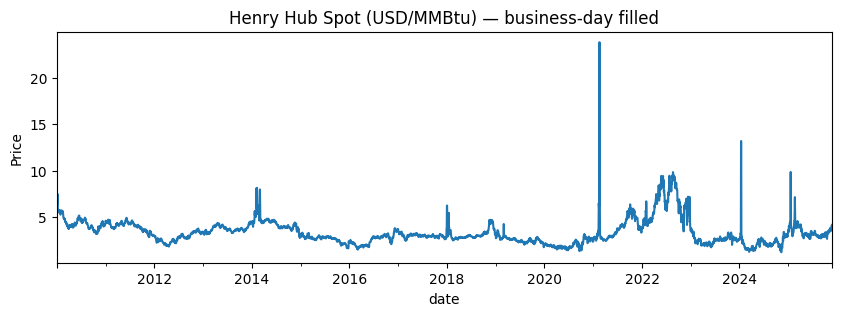

In [9]:
df_biz.set_index("date")["price"].plot(figsize=(10,3))
plt.title("Henry Hub Spot (USD/MMBtu) — business-day filled")
plt.ylabel("Price")
plt.show()